Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.png)

# Automated Machine Learning
_**Orange Juice Sales Forecasting**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Compute](#Compute)
1. [Data](#Data)
1. [Train](#Train)
1. [Predict](#Predict)
1. [Operationalize](#Operationalize)

## Introduction
In this example, we use AutoML to train, select, and operationalize a time-series forecasting model for multiple time-series.

Make sure you have executed the [configuration notebook](../../../configuration.ipynb) before running this notebook.

The examples in the follow code samples use the University of Chicago's Dominick's Finer Foods dataset to forecast orange juice sales. Dominick's was a grocery chain in the Chicago metropolitan area.

## Setup

In [3]:
import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig

As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem. 

In [4]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-ojforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.83
Subscription ID,f0e66588-3d18-4097-84a3-23ca7fd53b26
Workspace,docs-ws
SKU,Enterprise
Resource Group,docs-aml
Location,japaneast
Run History Name,automl-ojforecasting


## Compute

You will need to create a [compute target](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute) for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.

### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [5]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "cpu-cluster-oj"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
    
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D2_V2", # for GPU, use "STANDARD_NC6"
                                                                vm_priority = 'lowpriority', # optional
                                                                max_nodes = 6)

    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
print('Checking cluster status...')
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)
    
# For a more detailed view of current AmlCompute status, use get_status().

Found existing compute target.
Checking cluster status...
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


## Data
You are now ready to load the historical orange juice sales data. We will load the CSV file into a plain pandas DataFrame; the time column in the CSV is called _WeekStarting_, so it will be specially parsed into the datetime type.

In [6]:
time_column_name = 'WeekStarting'
data = pd.read_csv("dominicks_OJ.csv", parse_dates=[time_column_name])
data.head()

# ※parse_dates = datetime型で読み込むcolumn名

# DataFrameの各行には、1つの店舗でのOJブランドの週ごとの販売量が保持されます。 
# データには、販売価格、その週にOJブランドが店舗で宣伝されたかどうかを示すフラグ、
# 店舗の場所に基づく顧客の人口統計情報も含まれます。 
# 歴史的な理由から、データには販売数量の対数も含まれています。 
# Dominickの食料品データは一般に、量の対数が一般的に好まれる計量経済モデリングテクニックを説明するために使用されます。

,WeekStarting,Store,Brand,Quantity,logQuantity,Advert,Price,Age60,COLLEGE,INCOME,Hincome150,Large HH,Minorities,WorkingWoman,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,1990-06-14,2,dominicks,10560,9.26,1,1.59,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
1,1990-06-14,2,minute.maid,4480,8.41,0,3.17,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
2,1990-06-14,2,tropicana,8256,9.02,0,3.87,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
3,1990-06-14,5,dominicks,1792,7.49,1,1.59,0.12,0.32,10.92,0.54,0.10,0.05,0.41,3.80,0.68,1.60,0.74
4,1990-06-14,5,minute.maid,4224,8.35,0,2.99,0.12,0.32,10.92,0.54,0.10,0.05,0.41,3.80,0.68,1.60,0.74


Each row in the DataFrame holds a quantity of weekly sales for an OJ brand at a single store. The data also includes the sales price, a flag indicating if the OJ brand was advertised in the store that week, and some customer demographic information based on the store location. For historical reasons, the data also include the logarithm of the sales quantity. The Dominick's grocery data is commonly used to illustrate econometric modeling techniques where logarithms of quantities are generally preferred.    

The task is now to build a time-series model for the _Quantity_ column. It is important to note that this dataset is comprised of many individual time-series - one for each unique combination of _Store_ and _Brand_. To distinguish the individual time-series, we thus define the **grain** - the columns whose values determine the boundaries between time-series: 

In [7]:
grain_column_names = ['Store', 'Brand']
nseries = data.groupby(grain_column_names).ngroups
print('Data contains {0} individual time-series.'.format(nseries))

# ここでのタスクは、_Quantity_列の時系列モデルを作成することです。 
# このデータセットは、_Store_と_Brand_の一意の組み合わせごとに1つずつ、
# 多くの個々の時系列で構成されることに注意することが重要です。 
# 個々の時系列を区別するために、**グレイン**-時系列間の境界を決定する値を持つ列を定義します

Data contains 249 individual time-series.


For demonstration purposes, we extract sales time-series for just a few of the stores:

In [10]:
use_stores = [2, 5, 8]
data_subset = data[data.Store.isin(use_stores)]
nseries = data_subset.groupby(grain_column_names).ngroups
print('Data subset contains {0} individual time-series.'.format(nseries))

Data subset contains 9 individual time-series.


### Data Splitting
We now split the data into a training and a testing set for later forecast evaluation. The test set will contain the final 20 weeks of observed sales for each time-series. The splits should be stratified by series, so we use a group-by statement on the grain columns.

In [12]:
n_test_periods = 20

def split_last_n_by_grain(df, n):
    """Group df by grain and split on last n rows for each group."""
    df_grouped = (df.sort_values(time_column_name) # Sort by ascending time
                  .groupby(grain_column_names, group_keys=False))
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-n:])
    return df_head, df_tail

train, test = split_last_n_by_grain(data_subset, n_test_periods)

# データを後の予測評価のためにトレーニングとテストセットに分割しました。 
# テストセットには、各時系列の観測された最後の20週間の売上が含まれます。 
# 分割はシリーズごとに階層化する必要があるため、グレイン列でグループ化ステートメントを使用します

### Upload data to datastore
The [Machine Learning service workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace), is paired with the storage account, which contains the default data store. We will use it to upload the train and test data and create [tabular datasets](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py) for training and testing. A tabular dataset defines a series of lazily-evaluated, immutable operations to load data from the data source into tabular representation.

In [13]:
train.to_csv (r'./dominicks_OJ_train.csv', index = None, header=True)
test.to_csv (r'./dominicks_OJ_test.csv', index = None, header=True)

In [14]:
datastore = ws.get_default_datastore()
datastore.upload_files(files = ['./dominicks_OJ_train.csv', './dominicks_OJ_test.csv'], target_path = 'dataset/', overwrite = True,show_progress = True)

# 本コマンド実施後、Azure Blob Storage にデータがあることを確認します
# [azureml-blobstore-bc117e3e-d3e7-447e-bd5b-f2deaec712f8 / dataset]

Uploading an estimated of 2 files
Uploading ./dominicks_OJ_test.csv
Uploading ./dominicks_OJ_train.csv
Uploaded ./dominicks_OJ_test.csv, 1 files out of an estimated total of 2
Uploaded ./dominicks_OJ_train.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_1532db9c6a884e50a9fff3d592ca8fa6

### Create dataset for training

In [15]:
from azureml.core.dataset import Dataset
train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path('dataset/dominicks_OJ_train.csv'))

In [16]:
train_dataset.to_pandas_dataframe().tail()

,WeekStarting,Store,Brand,Quantity,logQuantity,Advert,Price,Age60,COLLEGE,INCOME,Hincome150,Large HH,Minorities,WorkingWoman,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
847,1992-04-09,8,tropicana,16192,9.69,0,2.50,0.25,0.10,10.60,0.05,0.13,0.04,0.28,2.64,1.50,2.91,0.64
848,1992-04-16,8,tropicana,6528,8.78,0,2.89,0.25,0.10,10.60,0.05,0.13,0.04,0.28,2.64,1.50,2.91,0.64
849,1992-04-23,8,tropicana,8320,9.03,0,2.89,0.25,0.10,10.60,0.05,0.13,0.04,0.28,2.64,1.50,2.91,0.64
850,1992-04-30,8,tropicana,30784,10.33,1,2.16,0.25,0.10,10.60,0.05,0.13,0.04,0.28,2.64,1.50,2.91,0.64
851,1992-05-07,8,tropicana,18048,9.80,0,2.89,0.25,0.10,10.60,0.05,0.13,0.04,0.28,2.64,1.50,2.91,0.64


## Modeling

For forecasting tasks, AutoML uses pre-processing and estimation steps that are specific to time-series. AutoML will undertake the following pre-processing steps:
* Detect time-series sample frequency (e.g. hourly, daily, weekly) and create new records for absent time points to make the series regular. A regular time series has a well-defined frequency and has a value at every sample point in a contiguous time span 
* Impute missing values in the target (via forward-fill) and feature columns (using median column values) 
* Create grain-based features to enable fixed effects across different series
* Create time-based features to assist in learning seasonal patterns
* Encode categorical variables to numeric quantities

In this notebook, AutoML will train a single, regression-type model across **all** time-series in a given training set. This allows the model to generalize across related series. If you're looking for training multiple models for different time-series, please check out the forecasting grouping notebook. 

You are almost ready to start an AutoML training job. First, we need to separate the target column from the rest of the DataFrame: 

### [和訳]

予測タスクの場合、AutoMLは時系列に固有の前処理および推定ステップを使用します。 

AutoMLは、次の前処理手順を実行します。

* 時系列のサンプル頻度（1時間ごと、1日ごと、1週間ごとなど）を検出し、不在の時点の新しいレコードを作成して、系列を定期的にします。
  定期的な時系列には、明確に定義された頻度があり、連続するタイムスパンのすべてのサンプルポイントに値があります。
* ターゲット（欠損値を使用）とフィーチャ列（中央値を使用）の欠損値を代入します
* grain ベースの機能を作成して、さまざまなシリーズで固定効果を有効にします
* 季節のパターンの学習を支援する時間ベースの機能を作成する
* カテゴリ変数を数値にエンコードする

このノートブックでは、AutoMLは特定のトレーニングセットのすべての時系列にわたって単一の回帰タイプモデルをトレーニングします。これにより、関連するシリーズ全体でモデルを一般化できます。
異なる時系列の複数のモデルのトレーニングをお探しの場合は、予測グループ分けノートブックをご覧ください。

AutoMLトレーニングジョブを開始する準備がほぼ整いました。最初に、ターゲット列を残りのDataFrameから分離する必要があります。

In [17]:
target_column_name = 'Quantity'

## Train

The AutoMLConfig object defines the settings and data for an AutoML training job. Here, we set necessary inputs like the task type, the number of AutoML iterations to try, the training data, and cross-validation parameters. 

For forecasting tasks, there are some additional parameters that can be set: the name of the column holding the date/time, the grain column names, and the maximum forecast horizon. A time column is required for forecasting, while the grain is optional. If a grain is not given, AutoML assumes that the whole dataset is a single time-series. We also pass a list of columns to drop prior to modeling. The _logQuantity_ column is completely correlated with the target quantity, so it must be removed to prevent a target leak.

The forecast horizon is given in units of the time-series frequency; for instance, the OJ series frequency is weekly, so a horizon of 20 means that a trained model will estimate sales up to 20 weeks beyond the latest date in the training data for each series. In this example, we set the maximum horizon to the number of samples per series in the test set (n_test_periods). Generally, the value of this parameter will be dictated by business needs. For example, a demand planning organizaion that needs to estimate the next month of sales would set the horizon accordingly. Please see the [energy_demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand) for more discussion of forecast horizon.

Finally, a note about the cross-validation (CV) procedure for time-series data. AutoML uses out-of-sample error estimates to select a best pipeline/model, so it is important that the CV fold splitting is done correctly. Time-series can violate the basic statistical assumptions of the canonical K-Fold CV strategy, so AutoML implements a [rolling origin validation](https://robjhyndman.com/hyndsight/tscv/) procedure to create CV folds for time-series data. To use this procedure, you just need to specify the desired number of CV folds in the AutoMLConfig object. It is also possible to bypass CV and use your own validation set by setting the *validation_data* parameter of AutoMLConfig.

Here is a summary of AutoMLConfig parameters used for training the OJ model:

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**experiment_timeout_hours**|Experimentation timeout in hours.|
|**enable_early_stopping**|If early stopping is on, training will stop when the primary metric is no longer improving.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross-validation folds to use for model/pipeline selection|
|**enable_voting_ensemble**|Allow AutoML to create a Voting ensemble of the best performing models|
|**enable_stack_ensemble**|Allow AutoML to create a Stack ensemble of the best performing models|
|**debug_log**|Log file path for writing debugging information|
|**time_column_name**|Name of the datetime column in the input data|
|**grain_column_names**|Name(s) of the columns defining individual series in the input data|
|**drop_column_names**|Name(s) of columns to drop prior to modeling|
|**max_horizon**|Maximum desired forecast horizon in units of time-series frequency|

### [和訳]

AutoMLConfigオブジェクトは、AutoMLトレーニングジョブの設定とデータを定義します。ここでは、タスクタイプ、試行するAutoMLの反復回数、トレーニングデータ、相互検証パラメーターなどの必要な入力を設定します。

予測タスクの場合、設定できる追加パラメーターがいくつかあります。日付/時刻を保持する列の名前、粒度列名、最大予測期間です。予測には時間列が必要ですが、粒度はオプションです。粒度が指定されていない場合、AutoMLはデータセット全体が単一の時系列であると想定します。また、モデリングの前にドロップする列のリストを渡します。 logQuantity列はターゲット量と完全に相関しているため、ターゲットリークを防ぐために削除する必要があります。

予測期間は、時系列頻度の単位で与えられます。たとえば、OJシリーズの頻度は毎週であるため、20の期間は、トレーニング済みモデルが各シリーズのトレーニングデータの最新の日付から最大20週間の売上を見積もることを意味します。この例では、テストセットのシリーズごとのサンプル数（n_test_periods）に最大期間を設定します。通常、このパラメーターの値はビジネスニーズによって決まります。たとえば、来月の売上を予測する必要がある需要計画組織は、それに応じて max_horizon を設定します。予測期間の詳細については、energy_demand ノートブックを参照してください。

最後に、時系列データの相互検証（CV）手順に関する注意。 AutoMLは、サンプル外のエラー推定値を使用して最適なパイプライン/モデルを選択するため、CVフォールド分割が正しく行われることが重要です。時系列は、標準的なKフォールドCV戦略の基本的な統計的仮定に違反する可能性があるため、AutoMLは、時系列データのCVフォールドを作成するためのローリングオリジン検証手順を実装します。この手順を使用するには、AutoMLConfigオブジェクトで必要なCVフォールドの数を指定するだけです。 AutoMLConfigのvalidation_dataパラメーターを設定することにより、CVをバイパスして独自の検証セットを使用することもできます。

OJモデルのトレーニングに使用されるAutoMLConfigパラメーターの概要は次のとおりです。

In [18]:
time_series_settings = {
    'time_column_name': time_column_name,
    'grain_column_names': grain_column_names,
    'drop_column_names': ['logQuantity'],  # 'logQuantity' is a leaky feature, so we remove it.
    'max_horizon': 20 #n_test_periods
}

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_oj_sales_errors.log',
                             primary_metric='normalized_mean_absolute_error',
                             experiment_timeout_hours=0.25,
                             iterations=20,
                             max_concurrent_iterations=6,
                             #experiment_exit_score=0.02
                             training_data=train_dataset,                             
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3,
                             verbosity=logging.INFO,
                             **time_series_settings)

# option の追加：iterations=20, max_concurrent_iterations=6

You can now submit a new training run. Depending on the data and number of iterations this operation may take several minutes.
Information from each iteration will be printed to the console.

In [19]:
remote_run = experiment.submit(automl_config, show_output=True)
remote_run

# show_output = True に変更

Running on remote compute: cpu-cluster-oj
Parent Run ID: AutoML_80fc5bdc-3cf6-4921-9e7b-688080cf1f78

Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         5   StandardScalerWrapper LassoLars                0:07:30       0.0344    0.0344
         4   StandardScalerWrapper ElasticNet               0:07:31       0.0350    0.0344
         3   StandardSc

Experiment,Id,Type,Status,Details Page,Docs Page
automl-ojforecasting,AutoML_80fc5bdc-3cf6-4921-9e7b-688080cf1f78,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [20]:
remote_run.wait_for_completion()

{'runId': 'AutoML_80fc5bdc-3cf6-4921-9e7b-688080cf1f78',
 'target': 'cpu-cluster-oj',
 'status': 'Completed',
 'startTimeUtc': '2020-03-20T09:53:22.805331Z',
 'endTimeUtc': '2020-03-20T10:07:59.33594Z',
 'properties': {'num_iterations': '20',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_mean_absolute_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpu-cluster-oj',
  'RawAMLSettingsString': "{'name': 'automl-ojforecasting', 'path': None, 'subscription_id': 'f0e66588-3d18-4097-84a3-23ca7fd53b26', 'resource_group': 'docs-aml', 'workspace_name': 'docs-ws', 'region': 'japaneast', 'compute_target': 'cpu-cluster-oj', 'spark_service': None, 'azure_service': None, 'iterations': 20, 'primary_metric': 'normalized_mean_absolute_error', 'task_type': 'regression', 'data_script': None, 'validation_size': 0.0, 'n_cross_validations': 3, 'y_min': None, 'y_max': None, 'num_classes': None, 'featuri

In [21]:
# 以下2行を追加。Widget で結果確認。

from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### Retrieve the Best Model
Each run within an Experiment stores serialized (i.e. pickled) pipelines from the AutoML iterations. We can now retrieve the pipeline with the best performance on the validation dataset:

In [22]:
best_run, fitted_model = remote_run.get_output()
print(fitted_model.steps)
model_name = best_run.properties['model_name']

[('timeseriestransformer', TimeSeriesTransformer(logger=None,
           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('15', Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0... subsample=0.95, tol=0.0001, validation_fraction=0.1,
             verbose=0, warm_start=False))]))],
               flatten_transform=None,
               weights=[0.45454545454545453, 0.18181818181818182, 0.09090909090909091, 0.09090909090909091, 0.18181818181818182]))]


# Forecasting

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. First, we remove the target values from the test set:

In [23]:
X_test = test
y_test = X_test.pop(target_column_name).values

In [24]:
X_test.head()
# Quantity 列が無い事を確認

,WeekStarting,Store,Brand,logQuantity,Advert,Price,Age60,COLLEGE,INCOME,Hincome150,Large HH,Minorities,WorkingWoman,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
24192,1992-05-21,2,dominicks,9.18,0,1.69,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
24441,1992-05-28,2,dominicks,10.73,0,1.69,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
24675,1992-06-04,2,dominicks,9.95,0,1.74,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
24909,1992-06-11,2,dominicks,8.79,0,2.09,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
25152,1992-06-18,2,dominicks,8.52,0,2.05,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38


To produce predictions on the test set, we need to know the feature values at all dates in the test set. This requirement is somewhat reasonable for the OJ sales data since the features mainly consist of price, which is usually set in advance, and customer demographics which are approximately constant for each store over the 20 week forecast horizon in the testing data.

In [25]:
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

If you are used to scikit pipelines, perhaps you expected `predict(X_test)`. However, forecasting requires a more general interface that also supplies the past target `y` values. Please use `forecast(X,y)` as `predict(X)` is reserved for internal purposes on forecasting models.

The [energy demand forecasting notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand) demonstrates the use of the forecast function in more detail in the context of using lags and rolling window features. 

# Evaluate

To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE). 

It is a good practice to always align the output explicitly to the input, as the count and order of the rows may have changed during transformations that span multiple rows.

In [26]:
from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)

[Test data scores]

explained_variance:   0.208
r2_score:   0.205
spearman_correlation:   0.661
mean_absolute_percentage_error:   77.900
mean_absolute_error:   10257.856
normalized_mean_absolute_error:   0.077
median_absolute_error:   4029.144
normalized_median_absolute_error:   0.030
root_mean_squared_error:   18340.435
normalized_root_mean_squared_error:   0.139
root_mean_squared_log_error:   0.727
normalized_root_mean_squared_log_error:   0.160


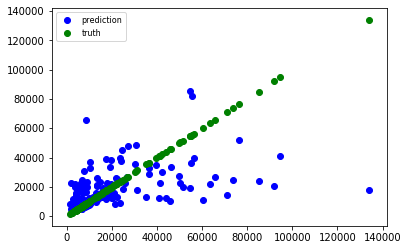

In [27]:
from azureml.automl.core._vendor.automl.client.core.common import metrics
from matplotlib import pyplot as plt
from automl.client.core.common import constants

# use automl metrics module
scores = metrics.compute_metrics_regression(
    df_all['predicted'],
    df_all[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None, None, None)

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

# Operationalize

_Operationalization_ means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.

In [28]:
description = 'AutoML OJ forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

AutoML80fc5bdc318


### Develop the scoring script

For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.

In [29]:
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

### Deploy the model as a Web Service on Azure Container Instance

In [31]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': "automl-forecasting"},
                                               description = "Automl forecasting sample service")

aci_service_name = 'automl-oj-forecast-03'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-oj-forecast-03
Running...........................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [32]:
aci_service.get_logs()

'2020-03-20T10:19:40,211522959+00:00 - rsyslog/run \n2020-03-20T10:19:40,211721860+00:00 - iot-server/run \n2020-03-20T10:19:40,212341563+00:00 - gunicorn/run \n2020-03-20T10:19:40,217744889+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_bb5f448562b2c4428838c28d9b22ab0f/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_bb5f448562b2c4428838c28d9b22ab0f/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_bb5f448562b2c4428838c28d9b22ab0f/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_bb5f448562b2c4428838c28d9b22ab0f/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_bb5f448562b2c4428838c28d9b22ab0f/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

### Call the service

In [33]:
import json
# The request data frame needs to have y_query column which corresponds to query.
X_query = X_test.copy()
X_query['y_query'] = np.NaN
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [73]:
print(y_fcst_all)

# 全店舗における全商品の、先20週分の販売数量の予測結果

           Brand  Store WeekStarting  forecast
0    dominicks    5     1992-05-14   7107.38  
1    minute.maid  5     1992-05-14   6063.83  
2    tropicana    5     1992-05-14   8076.83  
3    dominicks    8     1992-05-14   12116.39 
4    minute.maid  8     1992-05-14   8451.48  
5    tropicana    8     1992-05-14   9936.70  
6    dominicks    2     1992-05-21   9141.73  
7    minute.maid  2     1992-05-21   25444.15 
8    tropicana    2     1992-05-21   7112.20  
9    dominicks    5     1992-05-21   9207.48  
10   minute.maid  5     1992-05-21   48349.98 
11   tropicana    5     1992-05-21   8415.03  
12   dominicks    8     1992-05-21   16944.35 
13   minute.maid  8     1992-05-21   85555.68 
14   tropicana    8     1992-05-21   9968.97  
15   dominicks    2     1992-05-28   10586.07 
16   minute.maid  2     1992-05-28   5574.33  
17   tropicana    2     1992-05-28   7050.03  
18   dominicks    5     1992-05-28   10792.00 
19   minute.maid  5     1992-05-28   6928.08  
20   tropican

In [88]:
y_fcst_store2_tropicana = y_fcst_all[(y_fcst_all['Store'] == 2) & (y_fcst_all['Brand'] == 'tropicana') ]
print(y_fcst_store2_tropicana.sort_values('WeekStarting'))

# 店舗2 におけるトロピカーナの、先20週分の販売数量の予測結果

         Brand  Store WeekStarting  forecast
8    tropicana  2     1992-05-21   7112.20  
17   tropicana  2     1992-05-28   7050.03  
26   tropicana  2     1992-06-04   20107.86 
35   tropicana  2     1992-06-11   13345.92 
44   tropicana  2     1992-06-18   33799.02 
47   tropicana  2     1992-06-25   18721.06 
56   tropicana  2     1992-07-02   12023.14 
65   tropicana  2     1992-07-09   7011.28  
74   tropicana  2     1992-07-16   6542.63  
83   tropicana  2     1992-07-23   6536.87  
92   tropicana  2     1992-07-30   6157.90  
101  tropicana  2     1992-08-06   15670.25 
110  tropicana  2     1992-08-13   6645.52  
119  tropicana  2     1992-08-20   20539.57 
128  tropicana  2     1992-08-27   9050.26  
137  tropicana  2     1992-09-03   21842.07 
146  tropicana  2     1992-09-10   10496.27 
155  tropicana  2     1992-09-17   6996.95  
164  tropicana  2     1992-09-24   19032.69 
173  tropicana  2     1992-10-01   11953.45 


In [84]:
y_fcst_store2_dominicks = y_fcst_all[(y_fcst_all['Store'] == 2) & (y_fcst_all['Brand'] == 'dominicks') ]
print(y_fcst_store2_dominicks.sort_values('WeekStarting'))

# 店舗2 におけるドミニクスの、先20週分の販売数量の予測結果

         Brand  Store WeekStarting  forecast
6    dominicks  2     1992-05-21   9141.73  
15   dominicks  2     1992-05-28   10586.07 
24   dominicks  2     1992-06-04   13684.92 
33   dominicks  2     1992-06-11   4926.12  
42   dominicks  2     1992-06-18   4965.21  
45   dominicks  2     1992-06-25   22322.12 
54   dominicks  2     1992-07-02   9126.95  
63   dominicks  2     1992-07-09   32537.30 
72   dominicks  2     1992-07-16   8090.11  
81   dominicks  2     1992-07-23   10198.64 
90   dominicks  2     1992-07-30   28801.53 
99   dominicks  2     1992-08-06   19777.56 
108  dominicks  2     1992-08-13   7211.71  
117  dominicks  2     1992-08-20   12032.80 
126  dominicks  2     1992-08-27   23498.11 
135  dominicks  2     1992-09-03   4798.44  
144  dominicks  2     1992-09-10   4840.39  
153  dominicks  2     1992-09-17   11378.15 
162  dominicks  2     1992-09-24   12877.59 
171  dominicks  2     1992-10-01   9465.08  


In [89]:
y_fcst_store2_minutemaid = y_fcst_all[(y_fcst_all['Store'] == 2) & (y_fcst_all['Brand'] == 'minute.maid') ]
print(y_fcst_store2_minutemaid.sort_values('WeekStarting'))

# 店舗2 におけるミニッツメイドの、先20週分の販売数量の予測結果

           Brand  Store WeekStarting  forecast
7    minute.maid  2     1992-05-21   25444.15 
16   minute.maid  2     1992-05-28   5574.33  
25   minute.maid  2     1992-06-04   6255.01  
34   minute.maid  2     1992-06-11   5601.31  
43   minute.maid  2     1992-06-18   5546.21  
46   minute.maid  2     1992-06-25   7340.53  
55   minute.maid  2     1992-07-02   25985.02 
64   minute.maid  2     1992-07-09   21680.11 
73   minute.maid  2     1992-07-16   5202.84  
82   minute.maid  2     1992-07-23   18575.07 
91   minute.maid  2     1992-07-30   5330.38  
100  minute.maid  2     1992-08-06   15482.29 
109  minute.maid  2     1992-08-13   27343.28 
118  minute.maid  2     1992-08-20   39527.84 
127  minute.maid  2     1992-08-27   13583.57 
136  minute.maid  2     1992-09-03   12820.76 
145  minute.maid  2     1992-09-10   26738.69 
154  minute.maid  2     1992-09-17   5097.87  
163  minute.maid  2     1992-09-24   5748.97  
172  minute.maid  2     1992-10-01   22594.40 


### Delete the web service if desired

In [86]:
serv = Webservice(ws, 'automl-oj-forecast-02')
serv.delete()     # don't do it accidentally